# Fourier Feature Mapping on PytorchLightening with Gabor

In [3]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

from turboflow.utils import physics as phy

import torch
import pytorch_lightning as pl
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from turboflow.dataloaders import DataModule

torch.cuda.is_available()
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
print(device)

cuda:0


## Input data

Warning *** CHECK THE GRADIENT DIRECTION
Warning *** CHECK THE GRADIENT DIRECTION


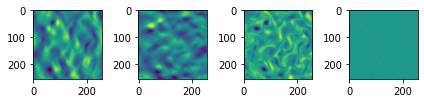

In [4]:
## SET UP DATA
path_to_data = '../data/2021-Turb2D_velocities.npy'
IMGs = np.load(path_to_data)
img_index = 42
X = IMGs[img_index,:,:,:2] / 255
U = IMGs[img_index,:,:,2]
V = IMGs[img_index,:,:,3]
t = np.arange(0,IMGs.shape[0],step=0.01)
Re = 3900

W = phy.compute_vorticity(U,V)
D = phy.compute_divergence(U,V)

plt.subplot(141)
plt.imshow(U)
plt.subplot(142)
plt.imshow(V)
plt.subplot(143)
plt.imshow(W)
plt.subplot(144)
plt.imshow(D)
plt.tight_layout()
plt.show()

In [5]:
img_index = 1
X1, X2 = IMGs[img_index,:,:,0], IMGs[img_index+1,:,:,0]
Y1, Y2 = IMGs[img_index,:,:,1], IMGs[img_index+1,:,:,1]
U1, U2 = IMGs[img_index,:,:,2], IMGs[img_index+1,:,:,2]
V1, V2 = IMGs[img_index,:,:,3], IMGs[img_index+1,:,:,3]
W1 = phy.compute_vorticity(U1, V1)
W2 = phy.compute_vorticity(U2, V2)
D1 = phy.compute_divergence(U1, V1)
D2 = phy.compute_divergence(U2, V2)

Warning *** CHECK THE GRADIENT DIRECTION
Warning *** CHECK THE GRADIENT DIRECTION
Warning *** CHECK THE GRADIENT DIRECTION
Warning *** CHECK THE GRADIENT DIRECTION


In [6]:
# normalize output
y = IMGs[img_index,:,:,2:4]
print(y.shape)
print(np.min(y), np.max(y))
y = y / np.max(np.abs(y))
print(np.min(y), np.max(y))

assert np.max(np.abs(y)) <= 1.0
assert np.max(np.abs(X)) <= 1.0

(256, 256, 2)
-3.497054 2.374197
-1.0 0.6789134511505971


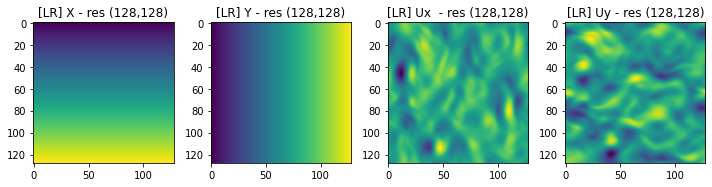

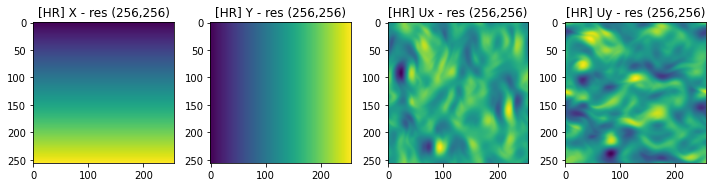

In [7]:
inputs = 2*X-1
labels = y

# downsampled resultion (one every 2)
ds = 2
Xtrain = inputs[::ds,::ds,:]
ytrain = labels[::ds,::ds,:]
Xtest = inputs
ytest = labels

plt.figure(figsize=(10,8))
plt.subplot(141)
plt.title('[LR] X - res (%d,%d)' % Xtrain[:,:,0].shape)
plt.imshow(Xtrain[:,:,0])
plt.subplot(142)
plt.title('[LR] Y - res (%d,%d)' % Xtrain[:,:,1].shape)
plt.imshow(Xtrain[:,:,1])
plt.subplot(143)
plt.title('[LR] Ux  - res (%d,%d)' % ytrain[:,:,0].shape)
plt.imshow(ytrain[:,:,0])
plt.subplot(144)
plt.title('[LR] Uy - res (%d,%d)' % ytrain[:,:,1].shape)
plt.imshow(ytrain[:,:,1])
plt.tight_layout()
plt.savefig('../figures/turboflow_train.pdf', dpi=150)
plt.show()

plt.figure(figsize=(10,8))
plt.subplot(141)
plt.title('[HR] X - res (%d,%d)' % Xtest[:,:,0].shape)
plt.imshow(Xtest[:,:,0])
plt.subplot(142)
plt.title('[HR] Y - res (%d,%d)' % Xtest[:,:,1].shape)
plt.imshow(Xtest[:,:,1])
plt.subplot(143)
plt.title('[HR] Ux - res (%d,%d)' % ytest[:,:,0].shape)
plt.imshow(ytest[:,:,0])
plt.subplot(144)
plt.title('[HR] Uy - res (%d,%d)' % ytest[:,:,1].shape)
plt.imshow(ytest[:,:,1])
plt.tight_layout()
plt.savefig('../figures/turboflow_test.pdf', dpi=150)
plt.show()

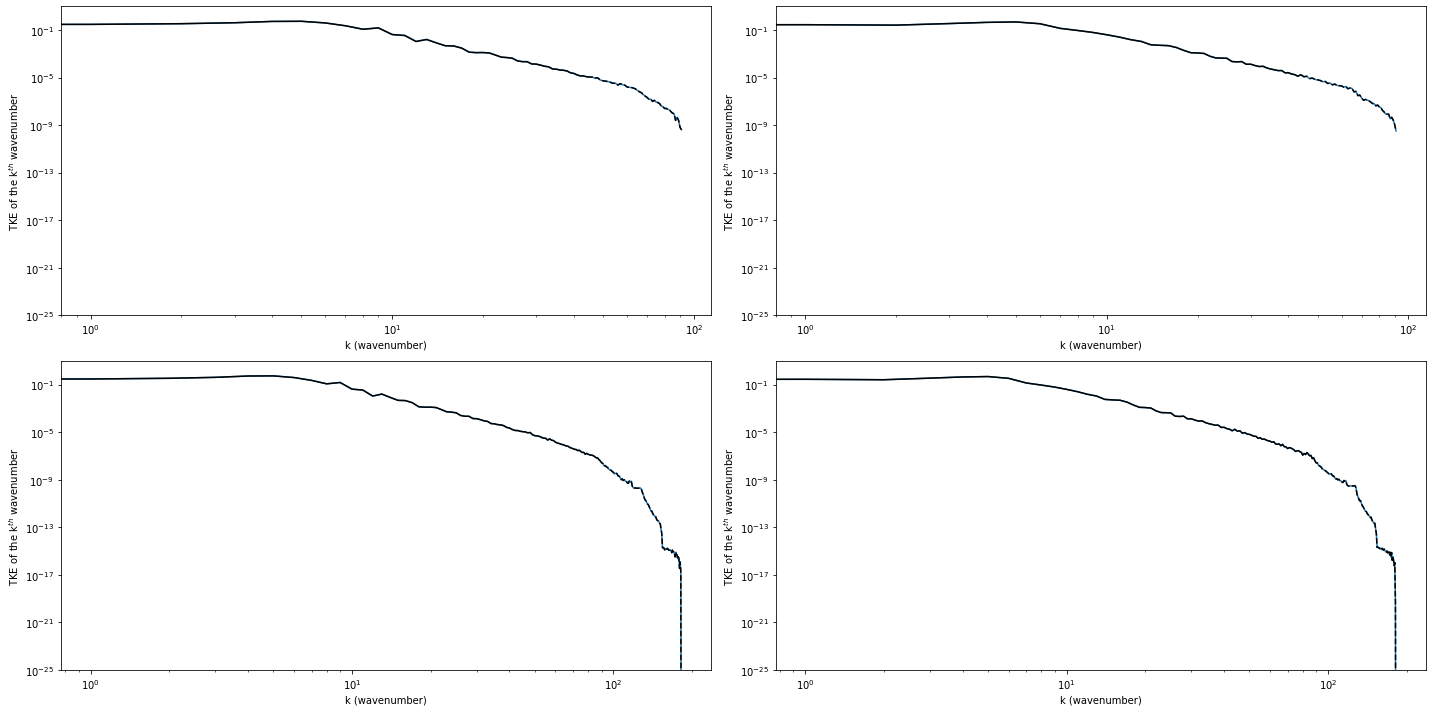

In [8]:
fig, axs = plt.subplots(2,2,figsize=(20,10))
phy.plot_energy_spec(phy.powerspec(ytrain[:,:,0]), axs[0,0])
phy.plot_energy_spec(phy.powerspec(ytrain[:,:,1]), axs[0,1])
phy.plot_energy_spec(phy.powerspec(ytest[:,:,0]), axs[1,0])
phy.plot_energy_spec(phy.powerspec(ytest[:,:,1]), axs[1,1])
plt.tight_layout()
plt.show()

## Fourier Features Mapping

In [9]:
def fourier_features(X, freqs):
    rFFM = X @ freqs.T
    return np.concatenate([np.cos(rFFM), np.sin(rFFM)], axis=-1)

In [10]:
np.random.seed(666)

ndim = 2
nfeatures = 512

# random Fourier Feature mapping
B = np.random.normal(0, 10, size=(nfeatures, ndim))

rFFM = fourier_features(Xtrain, B)
print('Fourier', rFFM.shape)

# for f in range(nfeatures):
#     plt.subplot(121)
#     plt.imshow(rFFM[:,:,f])
#     plt.subplot(122)
#     plt.imshow(rGFM[:,:,f])
#     plt.show()

# for f in range(5):
#     plt.plot(np.abs(rFFM[:,:,f].flatten()))
#     plt.show()

Fourier (128, 128, 1024)


In [11]:
print(Xtrain.shape)

(128, 128, 2)


## LEARNING TURBULENCES

In [12]:
dm_dict = {}

dm_dict['None'] = DataModule(
    train_data=[Xtrain, ytrain],
    val_data=[Xtrain, ytrain],
    test_data =[Xtest, ytest]
)
dm_dict['NonePh'] = DataModule(
    train_data=[Xtrain, ytrain],
    val_data=[Xtrain, ytrain],
    test_data =[Xtest, ytest]
)
dm_dict['Fourier10'] = DataModule(
    train_data=[Xtrain, ytrain],
    val_data=[Xtrain, ytrain],
    test_data =[Xtest, ytest]
)
dm_dict['Fourier10Ph'] = DataModule(
    train_data=[Xtrain, ytrain],
    val_data=[Xtrain, ytrain],
    test_data =[Xtest, ytest]
)

In [13]:
# # test data loader
# dm_dict['None'].prepare_data()
# for batch in dm_dict['Fourier10'].train_dataloader():
#     X, y = batch
#     print(X.shape)
#     print(y.shape)
    
# dm_dict['None'].prepare_data()
# for batch in dm_dict['Fourier10'].val_dataloader():
#     X, y = batch
#     print(X.shape)
#     print(y.shape)

In [14]:
import torch.nn as nn
import torch.nn.functional as F

def create_blockReLU(n_in, n_out):
    # do not work with ModuleList here either.
    block = nn.Sequential(
      nn.Linear(n_in, n_out),
      nn.ReLU()
    )
    return block

class MLP(pl.LightningModule):
    def __init__(self, layer_dimension, B, lam_div=1e-4, device=device):
        super().__init__()
        
        layers = []
        num_layers = len(layer_dimension)
        
        blocks = []
        for l in range(num_layers-2):
            blocks.append(create_blockReLU(layer_dimension[l], layer_dimension[l+1]))
            
        blocks.append(nn.Linear(layer_dimension[-2], layer_dimension[-1]))
        blocks.append(nn.Tanh())
        
        self.mlp = nn.Sequential(*blocks)
        
        # Fourier features
        self.B = B
        if self.B is not None:
            self.B = torch.from_numpy(self.B).float().to(device)
        
        # PINN losses
        self.lam_div = lam_div
    
    
    def forward(self, x):
        if self.B is not None:
            x = torch.matmul(2.*np.pi*x, self.B.T) # B x F
            x =  torch.cat([torch.sin(x), torch.cos(x)], axis=-1)
        # in lightning, forward defines the prediction/inference actions
        return self.mlp(x) 
    
    
    
    def training_step(self, batch, batch_idx):
        # training_step defined the train loop.
        # It is independent of forward
        x, x_true = batch
        x.requires_grad_(True)
        x_pred = self.forward(x)
        
        
        # physics based loss - div = 0
        u, v = torch.split(x_pred,1,-1)
        du_x = torch.autograd.grad(u, x, torch.ones_like(u), create_graph=True)[0]       
        dv_y = torch.autograd.grad(v, x, torch.ones_like(v), create_graph=True)[0]
        loss_div = torch.norm(du_x[...,0] + dv_y[...,1])
    
        # reconstruction loss
        loss_rec = F.mse_loss(x_pred, x_true)

        # losses 
        loss = loss_rec + self.lam_div*loss_div
        
        # Logging to TensorBoard by default
        self.log('train_loss', loss)
        self.log('train_loss_data', loss_rec)
        self.log('train_loss_div', loss_div)
        return loss
    
    
    def validation_step(self, batch, batch_idx):
        x, x_true = batch
        x_pred = self.forward(x)
        loss = F.mse_loss(x_pred, x_true)
        psnr = 10 * np.log(2*loss.item())
        self.log('valid_loss', loss, on_step=True)
        
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-4)
        return optimizer
    
model_dict = {}
max_iters = int(10e3)
model_dict = {}

In [21]:
layers = [2] + 3*[256] + [ytest.shape[-1]]
model_dict['None'] = MLP(layers, B=None, lam_div=0, device=device)
early_stop_callback = EarlyStopping(monitor='valid_loss')

trainer = pl.Trainer(gpus=1, 
                     check_val_every_n_epoch=200, 
                     max_epochs=max_iters, 
                     callbacks=[early_stop_callback])

trainer.fit(model_dict['None'], dm_dict['None'])

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | Params
------------------------------------
0 | mlp  | Sequential | 132 K 
------------------------------------
132 K     Trainable params
0         Non-trainable params
132 K     Total params
0.531     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/home/dicarlo_d/Documents/Code/TurboSuperResultion/venv/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 48 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)
/home/dicarlo_d/Documents/Code/TurboSuperResultion/venv/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 48 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [22]:
layers = [2*512] + 3*[256] + [ytest.shape[-1]]
B = np.random.normal(0, 10, size=(512, ndim))
model_dict['Fourier10'] = MLP(layers, B, lam_div=0, device=device)
early_stop_callback = EarlyStopping(monitor='valid_loss')

trainer = pl.Trainer(gpus=1, 
                     check_val_every_n_epoch=200, 
                     max_epochs=max_iters, 
                     callbacks=[early_stop_callback])

trainer.fit(model_dict['Fourier10'] , dm_dict['Fourier10'])

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | Params
------------------------------------
0 | mlp  | Sequential | 394 K 
------------------------------------
394 K     Trainable params
0         Non-trainable params
394 K     Total params
1.578     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [23]:
layers = [2] + 3*[256] + [ytest.shape[-1]]
max_iters = int(30e3)
model_dict['NonePh'] = MLP(layers, B=None, lam_div=1e-5, device=device)
early_stop_callback = EarlyStopping(monitor='valid_loss')

trainer = pl.Trainer(gpus=1, 
                     check_val_every_n_epoch=200, 
                     max_epochs=max_iters, 
                     callbacks=[early_stop_callback])

trainer.fit(model_dict['NonePh'], dm_dict['NonePh'])

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | Params
------------------------------------
0 | mlp  | Sequential | 132 K 
------------------------------------
132 K     Trainable params
0         Non-trainable params
132 K     Total params
0.531     Total estimated model params size (MB)


(128, 128, 2)
(128, 128, 2)
(128, 128, 2)
(128, 128, 2)
(256, 256, 2)
(256, 256, 2)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [24]:
layers = [2*512] + 3*[256] + [ytest.shape[-1]]
B = np.random.normal(0, 10, size=(512, ndim))
max_iters = int(30e3)
model_dict['Fourier10Ph'] = MLP(layers, B, lam_div=1e-5, device=device)
early_stop_callback = EarlyStopping(monitor='valid_loss')

trainer = pl.Trainer(gpus=1, 
                     check_val_every_n_epoch=200, 
                     max_epochs=max_iters, 
                     callbacks=[early_stop_callback])

trainer.fit(model_dict['Fourier10Ph'] , dm_dict['Fourier10Ph'])

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | Params
------------------------------------
0 | mlp  | Sequential | 394 K 
------------------------------------
394 K     Trainable params
0         Non-trainable params
394 K     Total params
1.578     Total estimated model params size (MB)


(128, 128, 2)
(128, 128, 2)
(128, 128, 2)
(128, 128, 2)
(256, 256, 2)
(256, 256, 2)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [25]:
def my_pred(ngrid, model):
    model.eval().to(device)
    coords = np.linspace(-1, 1, ngrid, endpoint=False)
    coords = np.stack(np.meshgrid(coords, coords), -1) # X x Y x 2
    tmp = coords[:,:,0].copy()
    coords[:,:,0] = coords[:,:,1]
    coords[:,:,1] = tmp
    pred = model(torch.from_numpy(coords).float().to(device))
    ypred = pred.cpu().detach().numpy().squeeze()
    return ypred

In [26]:
from scipy import interpolate

def my_intr(size, X, y):

    xx, yy = Xtrain[:,:,0], X[:,:,1]
    x = np.linspace(-1,1,y[:,:,0].shape[0])
    y = np.linspace(-1,1,y[:,:,0].shape[1])
    z = ytrain[:,:,0]

    f_interp2d = interpolate.interp2d(x, y, z, kind='linear') # 'cubic'

    x = np.linspace(-1,1,size)
    y = np.linspace(-1,1,size)
    Ipred = f_interp2d(x, y)
    return Ipred

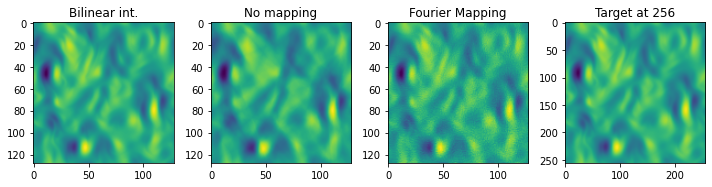

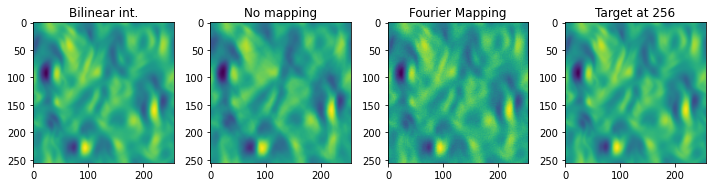

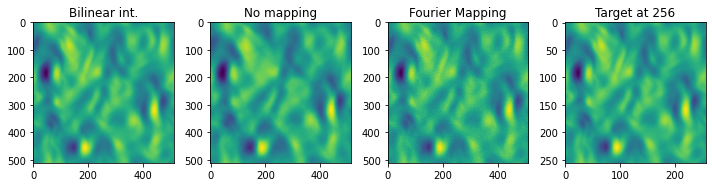

In [27]:
for res in [128, 256, 512]:

    Npred = my_pred(res, model_dict['None'])
    Fpred = my_pred(res, model_dict['Fourier10'])
    Ipred = my_intr(res, Xtrain, ytrain)

    figsize = (10,10)
    fig, axs = plt.subplots(1,4, figsize=figsize)
    axs[0].imshow(Ipred)
    axs[0].set_title('Bilinear int.')
    axs[1].imshow(Npred[:,:,0])
    axs[1].set_title('No mapping')
    axs[2].imshow(Fpred[:,:,0])
    axs[2].set_title('Fourier Mapping')
    axs[3].imshow(ytest[:,:,0].squeeze())
    axs[3].set_title('Target at %d' % 256)
    plt.tight_layout()
    plt.show()

In [28]:
Npred256 = my_pred(256, model_dict['None'])
Npred256ph = my_pred(256, model_dict['NonePh'])
Fpred256 = my_pred(256, model_dict['Fourier10'])
Fpred256ph = my_pred(256, model_dict['Fourier10Ph'])
Ipred256 = my_intr(256,Xtrain, ytrain)
Npred512 = my_pred(512, model_dict['None'])
Fpred512 = my_pred(512, model_dict['Fourier10'])
Npred512Ph = my_pred(512, model_dict['NonePh'])
Fpred512Ph = my_pred(512, model_dict['Fourier10Ph'])
Ipred512 = my_intr(512,Xtrain, ytrain)

In [ ]:
fig, axs = plt.subplots(figsize=(10,10))
plt.loglog(phy.powerspec(ytrain[:,:,0]), 'C0--', label='target at 128', alpha=0.5)
plt.loglog(phy.powerspec(ytest[:,:,0]), 'C0--', label='target at 256', alpha=0.9)
plt.loglog(phy.powerspec(Ipred256), 'C1', label='Intrp256', alpha=0.5)
plt.loglog(phy.powerspec(Ipred512), 'C1',  label='Intrp512', alpha=0.8)
plt.loglog(phy.powerspec(Npred256[:,:,0]), 'C2', label='None256', alpha=0.5)
plt.loglog(phy.powerspec(Npred512[:,:,0]), 'C2', label='None512', alpha=0.8)
plt.loglog(phy.powerspec(Npred512Ph[:,:,0]), 'C2', label='None512Ph', alpha=1)
plt.loglog(phy.powerspec(Fpred256[:,:,0]), 'C3', label='RFF256', alpha=0.5)
plt.loglog(phy.powerspec(Fpred512[:,:,0]), 'C3', label='RFF512', alpha=0.8)
plt.loglog(phy.powerspec(Fpred512Ph[:,:,0]), 'C3', label='RFF512Ph', alpha=1)
plt.ylim([10**-9,10])
plt.ylabel(r'Energy spectrum $\log E(k)$')
plt.xlabel(r'Wavenumber, $k$')
plt.legend()
plt.savefig('../figures/turboflow_energy_PHY.pdf', dpi=300)
plt.show()

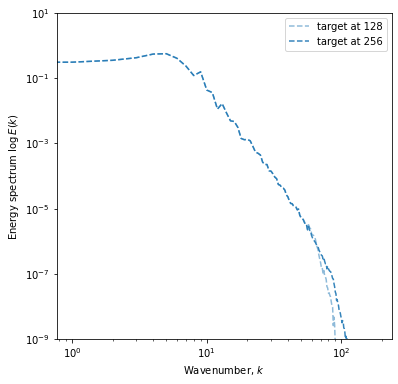

In [246]:
fig, axs = plt.subplots(figsize=(6,6))
plt.loglog(phy.powerspec(ytrain[:,:,0]), 'C0--', label='target at 128', alpha=0.5)
plt.loglog(phy.powerspec(ytest[:,:,0]), 'C0--', label='target at 256', alpha=0.9)
# plt.loglog(phy.powerspec(Ipred256), 'C1', label='Intrp256', alpha=0.5)
# plt.loglog(phy.powerspec(Ipred512), 'C1',  label='Intrp512', alpha=0.8)
# plt.loglog(phy.powerspec(Npred256[:,:,0]), 'C2', label='None256', alpha=0.5)
# plt.loglog(phy.powerspec(Npred512[:,:,0]), 'C2', label='None512', alpha=0.8)
# plt.loglog(phy.powerspec(Npred512Ph[:,:,0]), 'C2', label='None512Ph', alpha=1)
# plt.loglog(phy.powerspec(Fpred256[:,:,0]), 'C3', label='RFF256', alpha=0.5)
# plt.loglog(phy.powerspec(Fpred512[:,:,0]), 'C3', label='RFF512', alpha=0.8)
# plt.loglog(phy.powerspec(Fpred512Ph[:,:,0]), 'C3', label='RFF512Ph', alpha=1)
plt.ylim([10**-9,10])
plt.ylabel(r'Energy spectrum $\log E(k)$')
plt.xlabel(r'Wavenumber, $k$')
plt.legend()
plt.savefig('../figures/turboflow_energy_TGT.pdf', dpi=300)
plt.show()

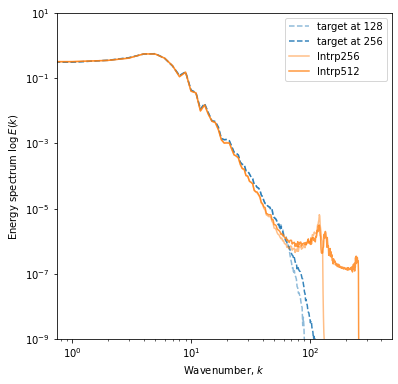

In [247]:
fig, axs = plt.subplots(figsize=(6,6))
plt.loglog(phy.powerspec(ytrain[:,:,0]), 'C0--', label='target at 128', alpha=0.5)
plt.loglog(phy.powerspec(ytest[:,:,0]), 'C0--', label='target at 256', alpha=0.9)
plt.loglog(phy.powerspec(Ipred256), 'C1', label='Intrp256', alpha=0.5)
plt.loglog(phy.powerspec(Ipred512), 'C1',  label='Intrp512', alpha=0.8)
# plt.loglog(phy.powerspec(Npred256[:,:,0]), 'C2', label='None256', alpha=0.5)
# plt.loglog(phy.powerspec(Npred512[:,:,0]), 'C2', label='None512', alpha=0.8)
# plt.loglog(phy.powerspec(Npred512Ph[:,:,0]), 'C2', label='None512Ph', alpha=1)
# plt.loglog(phy.powerspec(Fpred256[:,:,0]), 'C3', label='RFF256', alpha=0.5)
# plt.loglog(phy.powerspec(Fpred512[:,:,0]), 'C3', label='RFF512', alpha=0.8)
# plt.loglog(phy.powerspec(Fpred512Ph[:,:,0]), 'C3', label='RFF512Ph', alpha=1)
plt.ylim([10**-9,10])
plt.ylabel(r'Energy spectrum $\log E(k)$')
plt.xlabel(r'Wavenumber, $k$')
plt.legend()
plt.savefig('../figures/turboflow_energy_INT.pdf', dpi=300)
plt.show()

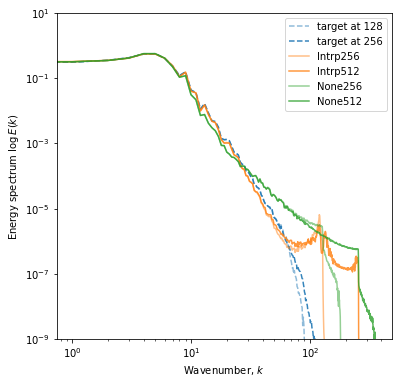

In [248]:
fig, axs = plt.subplots(figsize=(6,6))
plt.loglog(phy.powerspec(ytrain[:,:,0]), 'C0--', label='target at 128', alpha=0.5)
plt.loglog(phy.powerspec(ytest[:,:,0]), 'C0--', label='target at 256', alpha=0.9)
plt.loglog(phy.powerspec(Ipred256), 'C1', label='Intrp256', alpha=0.5)
plt.loglog(phy.powerspec(Ipred512), 'C1',  label='Intrp512', alpha=0.8)
plt.loglog(phy.powerspec(Npred256[:,:,0]), 'C2', label='None256', alpha=0.5)
plt.loglog(phy.powerspec(Npred512[:,:,0]), 'C2', label='None512', alpha=0.8)
# plt.loglog(phy.powerspec(Npred512Ph[:,:,0]), 'C2', label='None512Ph', alpha=1)
# plt.loglog(phy.powerspec(Fpred256[:,:,0]), 'C3', label='RFF256', alpha=0.5)
# plt.loglog(phy.powerspec(Fpred512[:,:,0]), 'C3', label='RFF512', alpha=0.8)
# plt.loglog(phy.powerspec(Fpred512Ph[:,:,0]), 'C3', label='RFF512Ph', alpha=1)
plt.ylim([10**-9,10])
plt.ylabel(r'Energy spectrum $\log E(k)$')
plt.xlabel(r'Wavenumber, $k$')
plt.legend()
plt.savefig('../figures/turboflow_energy_NONE.pdf', dpi=300)
plt.show()

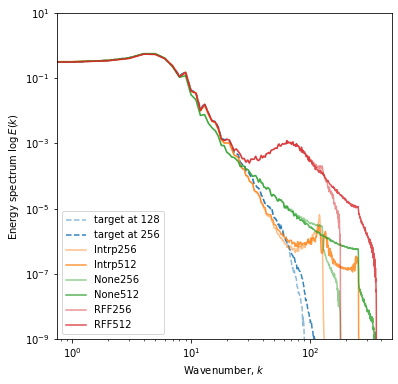

In [249]:
fig, axs = plt.subplots(figsize=(6,6))
plt.loglog(phy.powerspec(ytrain[:,:,0]), 'C0--', label='target at 128', alpha=0.5)
plt.loglog(phy.powerspec(ytest[:,:,0]), 'C0--', label='target at 256', alpha=0.9)
plt.loglog(phy.powerspec(Ipred256), 'C1', label='Intrp256', alpha=0.5)
plt.loglog(phy.powerspec(Ipred512), 'C1',  label='Intrp512', alpha=0.8)
plt.loglog(phy.powerspec(Npred256[:,:,0]), 'C2', label='None256', alpha=0.5)
plt.loglog(phy.powerspec(Npred512[:,:,0]), 'C2', label='None512', alpha=0.8)
# plt.loglog(phy.powerspec(Npred512Ph[:,:,0]), 'C2', label='None512Ph', alpha=1)
plt.loglog(phy.powerspec(Fpred256[:,:,0]), 'C3', label='RFF256', alpha=0.5)
plt.loglog(phy.powerspec(Fpred512[:,:,0]), 'C3', label='RFF512', alpha=0.8)
# plt.loglog(phy.powerspec(Fpred512Ph[:,:,0]), 'C3', label='RFF512Ph', alpha=1)
plt.ylim([10**-9,10])
plt.ylabel(r'Energy spectrum $\log E(k)$')
plt.xlabel(r'Wavenumber, $k$')
plt.legend()
plt.savefig('../figures/turboflow_energy_RFF.pdf', dpi=300)
plt.show()

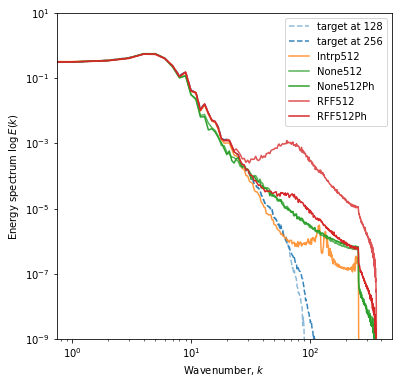

In [252]:
fig, axs = plt.subplots(figsize=(6,6))
plt.loglog(phy.powerspec(ytrain[:,:,0]), 'C0--', label='target at 128', alpha=0.5)
plt.loglog(phy.powerspec(ytest[:,:,0]), 'C0--', label='target at 256', alpha=0.9)
# plt.loglog(phy.powerspec(Ipred256), 'C1', label='Intrp256', alpha=0.5)
plt.loglog(phy.powerspec(Ipred512), 'C1',  label='Intrp512', alpha=0.8)
# plt.loglog(phy.powerspec(Npred256[:,:,0]), 'C2', label='None256', alpha=0.5)
plt.loglog(phy.powerspec(Npred512[:,:,0]), 'C2', label='None512', alpha=0.8)
plt.loglog(phy.powerspec(Npred512Ph[:,:,0]), 'C2', label='None512Ph', alpha=1)
# plt.loglog(phy.powerspec(Fpred256[:,:,0]), 'C3', label='RFF256', alpha=0.5)
plt.loglog(phy.powerspec(Fpred512[:,:,0]), 'C3', label='RFF512', alpha=0.8)
plt.loglog(phy.powerspec(Fpred512Ph[:,:,0]), 'C3', label='RFF512Ph', alpha=1)
plt.ylim([10**-9,10])
plt.ylabel(r'Energy spectrum $\log E(k)$')
plt.xlabel(r'Wavenumber, $k$')
plt.legend()
plt.savefig('../figures/turboflow_energy_PHY.pdf', dpi=300)
plt.show()